# Ecuaciones Diferenciales Ordinarias Neuronales

Una parte importante de los procesos se puede describir mediante ecuaciones diferenciales: ya sea la evolución de los sistemas físicos, las condiciones médicas de un paciente, las propiedades fundamentales de los mercados, etc. Estos datos son de naturaleza secuencial y continua, lo que significa que las observaciones son meras realizaciones de algún estado en continuo cambio.

También hay otro tipo de datos secuenciales que son discretos, los datos NLP, por ejemplo: su estado cambia discretamente, de un símbolo a otro, de una palabra a otra.

Hoy en día, ambos tipos se procesan normalmente mediante redes neuronales recurrentes. Sin embargo, son esencialmente diferentes en su naturaleza y parece que deberían ser tratados de manera diferente.

Hay un [articulo](https://arxiv.org/abs/1806.07366) muy interesante que intenta abordar este problema. Los autores proponen un enfoque muy prometedor, al que llaman **Ecuaciones Diferenciales Ordinarias Neurales**.

Trataremos de reproducir y resumir los resultados del artículo original, haciendo que sea un poco más fácil familiarizarse con la idea. Según creo, esta nueva arquitectura pronto puede estar, entre las redes convolucionales y recurrentes, en una caja de herramientas de cualquier científico de datos.

Imagine un problema: hay un proceso siguiendo una EDO desconocida y algunas observaciones (ruidosas) a lo largo de su trayectoria

$$
\frac{dz}{dt} = f(z(t), t) \tag{1}
$$
$$
\{(z_0, t_0),(z_1, t_1),...,(z_M, t_M)\} - \text{observaciones}
$$

¿Es posible encontrar una aproximación $\widehat{f}(z, t, \theta)$ de la funcion dinamica $f(z, t)$?


Primero, considere una tarea algo más simple: solo hay 2 observaciones, al principio y al final de la trayectoria, $(z_0, t_0), (z_1, t_1)$. Uno inicia la evolución del sistema desde $z_0, t_0$ por el tiempo $t_1 - t_0$ con alguna función dinámica parametrizada usando cualquier solver para EDOs. Después de eso, uno termina estando en algún estado nuevo $\hat{z_1}, t_1$, lo compara con la observación $z_1$, y trata de minimizar la diferencia variando los parámetros $\theta$.

O, más formalmente, considere optimizar la siguiente función de pérdida $L(\hat{z_1})$:

$$
L(z(t_1)) = L \Big( \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big) \tag{2}
$$

<img src=assets/backprop.png width=600></img>

<p style="text-align: center">Figura 1: La retropropagación continua del gradiente requiere resolver la EDO aumentada hacia atrás en el tiempo. <br /> Las flechas representan el ajuste de gradientes retropropagados con gradientes de observaciones. <br />
Figura original del articulo</p>

La figura de arriba representa lo que está pasando. La trayectoria negra representa la resolución de la ODE durante la propagación hacia adelante. Las flechas rojas representan la resolución de la EDO adjunta durante la retropropagación.

Para optimizar $L$, es necesario calcular los gradientes con respecto a sus parámetros: $z(t_0), t_0, t_1, \theta$. Para hacer esto, primero determinemos cómo la pérdida depende del estado en cada momento del tiempo $(z(t))$:
$$
a(t) = -\frac{\partial L}{\partial z(t)} \tag{3}
$$
$a(t)$ es llamado *adjunto* (adjoint), su dinámica está dada por otra EDO, que puede considerarse como un análogo instantáneo de la regla de la cadena

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} \tag{4}
$$
La derivación real de esta fórmula en particular se puede encontrar en el apéndice del artículo original.

Todos los vectores aquí se consideran vectores de fila, mientras que el documento original usa representaciones tanto de columna como de fila.

Entonces se puede calcular
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{5}
$$

Para calcular los gradientes con respecto a $t$ y $\theta$ uno puede pensar en ellos como si fueran parte del estado aumentado

$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

El estado adjunto a este estado aumentado es entonces
$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

Gradiente de la dinámica aumentada

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix} 
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

La EDO de estado adjunto de la fórmula (4) es entonces
$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

Al resolver este problema adjunto de valor inicial de ODE aumentada, se obtiene
$$
\begin{align*}
\frac{\partial L}{\partial z(t_0)} &= \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{10}\\
\frac{\partial L}{\partial \theta} &= \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt \tag{11}\\
\frac{\partial L}{\partial t_0} &= \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt \tag{12}\\
\end{align*}
$$

que, junto con,
$$
\frac{\partial L}{\partial t_1} = - a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} \tag{13}
$$
complementa gradientes con respecto a todos los parámetros de ODESolve.

Los gradientes (10), (11), (12), (13) se pueden calcular juntos durante una sola llamada de ODESolve con dinámica de estado aumentada (9).

<img src=assets/pseudocode.png width=800></img>
<div align="center">Figura del articulo original</div>

El algoritmo anterior describe la retropropagación de gradientes para el problema de valor inicial ODE con observaciones posteriores. Este algoritmo se encuentra en el corazón de las EDO neuronales.

En caso de que haya muchas observaciones a lo largo de la trayectoria, se calcula la dinámica ODE aumentada adjunta para observaciones posteriores, ajustando los gradientes retropropagados con gradientes directos en los momentos de observación, como se muestra arriba en la *figura 1*.

# Implementacion

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [2]:
from api.utils_EDO_Neuronal import *

Por simplicidad implementaremos el solver problemas de valor inicial de Euler, sin embargo, cualquier método explícito o implícito servirá.

También implementamos una superclase de función dinámica parametrizada en forma de red neuronal con un par de métodos útiles.

Primero, uno necesita poder aplanar todos los parámetros de los que depende la función.

En segundo lugar, es necesario implementar un método que calcule la dinámica aumentada. Esta dinámica aumentada depende del gradiente de la función con resepcto a sus entradas y parámetros. Para no tener que especificarlos a mano para cada nueva arquitectura, utilizaremos el método **torch.autograd.grad**.

Esto esta implementado en api `models_methods`.

La clase `ODEAdjoint` encapsula pasos hacia adelante y hacia atrás de *EDO Neuronal*. Tenemos que separarlo del principal ***torch.nn.Module*** porque la función de retroceso personalizado no se puede implementar dentro del Módulo, pero se puede implementar dentro de ***torch.autograd.Function***. Así que esto es solo una pequeña solución.

Esta función es la base de todo el método EDo Neuronal.

Ponemos la función adjunta ode en **nn.Module** para mayor comodidad.

# Aplicacion

## _Aprendiendo la función de dinámica verdadera (prueba de concepto)_

Como prueba de concepto, ahora probaremos si Neural EDO puede realmente restaurar la función dinámica real utilizando datos de muestra.

Para probar esto, especificaremos una EDO, la evolucionaremos y muestrearemos puntos en su trayectoria, y luego la restauraremos.

Primero, probaremos una EDO lineal simple. La dinámica se da con una matriz.

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

La función entrenada aquí también es una matriz simple.

![leaning gif](assets/linear_learning.gif)

A continuación, dinámicas un poco más sofisticadas (esta vez sin un gif ya que su proceso de aprendizaje no es tan satisfactorio  :/ ).
La función entrenada aquí es MLP con una capa oculta.
![complicated result](assets/comp_result.png)

Una dinamica lineal implementada en `LinearODEF`.

La dinámica se da simplemente con una matriz `SpiralFunctionExample`.

Se optimizará la función de dinámica lineal aleatoria inicial `RandomLinearODEF`.

Dinámicas más sofisticadas para crear trayectorias `TestODEF`.

La función dinámica a optimizar es MLP `NNODEF`.

In [3]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

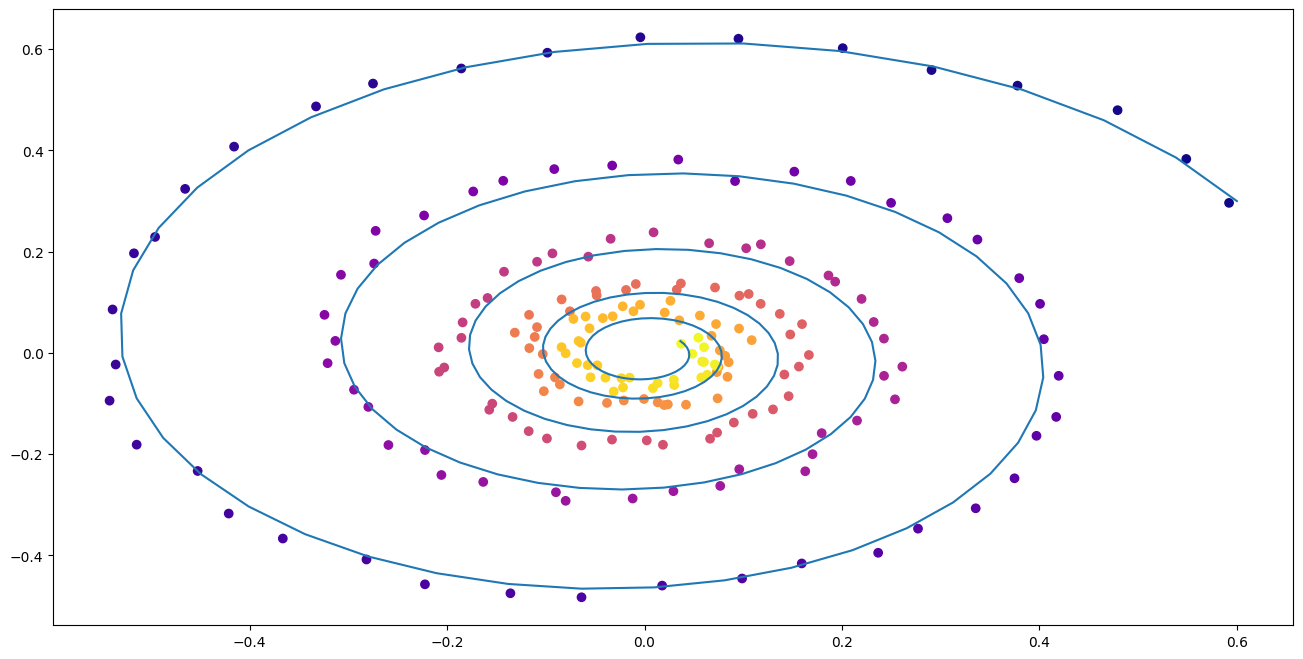

In [4]:
conduct_experiment(ode_true, ode_trained, 3000, "linear", plot_freq=50)

In [5]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

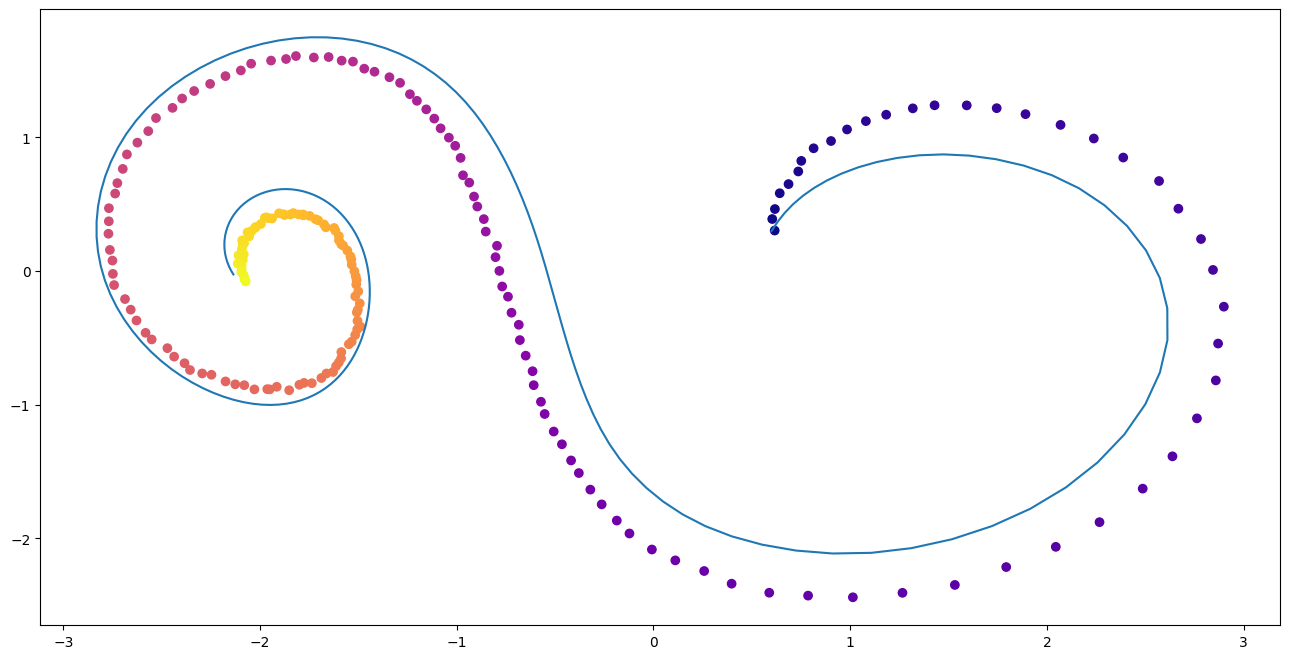

In [6]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=50)

Como se puede ver, las EDO neuronales tienen bastante éxito en la aproximación de la dinámica. Ahora veamos si se pueden usar en una tarea un poco más complicada (MNIST, experiemntemos y veamos la wea xD).

## EDOs Neuronales inspiradas en ResNets 

En redes residuales cambios de estado ocultos según la fórmula
$$
h_{t+1} = h_{t} + f(h_{t}, \theta_{t})
$$

donde $t \in \{0...T\}$ es el número de bloque residual y $f$ es una función aprendida por capas dentro del bloque.

Si uno toma un límite de un número infinito de bloques residuales con pasos más pequeños, obtiene que la dinámica continua de unidades ocultas es una ecuación diferencial ordinaria tal como la teníamos arriba.

$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$

A partir de la capa de entrada $h(0)$, se puede definir la capa de salida $h(T)$ como la solución a este problema de valor inicial en algún momento T.

Ahora podemos tratar a $\theta$ como el parámetro compartido entre todos los bloques residuales infinitesimalmente pequeños.

### Probando la arquitectura EDO Neuronal en MNIST

En esta sección, probamos la capacidad de las EDO neuronales para usarse como un componente en arquitecturas más convencionales.
En particular, usaremos EDO Neuronal en lugar de bloques residuales en el clasificador MNIST.

<img src="assets/mnist_example.png" width=400></img>

In [7]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [8]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [9]:
optimizer = torch.optim.Adam(model.parameters())

In [10]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Epoca de entrenamiento {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Perdida de entrenamiento: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [11]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Probando...")
    with torch.no_grad():
        # La funcion tqdm es una maravilla :3
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Precision de la prueba: {:.3f}%".format(accuracy))

In [12]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Probando...


C:\Users\Det-Pc\AppData\Local\Temp\ipykernel_3052\3531354830.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 7.110%
Epoca de entrenamiento 1...


C:\Users\Det-Pc\AppData\Local\Temp\ipykernel_3052\139253681.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.15660
Probando...


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 97.560%
Epoca de entrenamiento 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.04870
Probando...


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 98.880%
Epoca de entrenamiento 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.03750
Probando...


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 98.660%
Epoca de entrenamiento 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.02861
Probando...


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 98.730%
Epoca de entrenamiento 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Perdida de entrenamiento: 0.02417
Probando...


  0%|          | 0/79 [00:00<?, ?it/s]

Precision de la prueba: 99.030%


<AxesSubplot: title={'center': 'Error de entrenamiento'}, xlabel='cum_data'>

<Figure size 900x500 with 0 Axes>

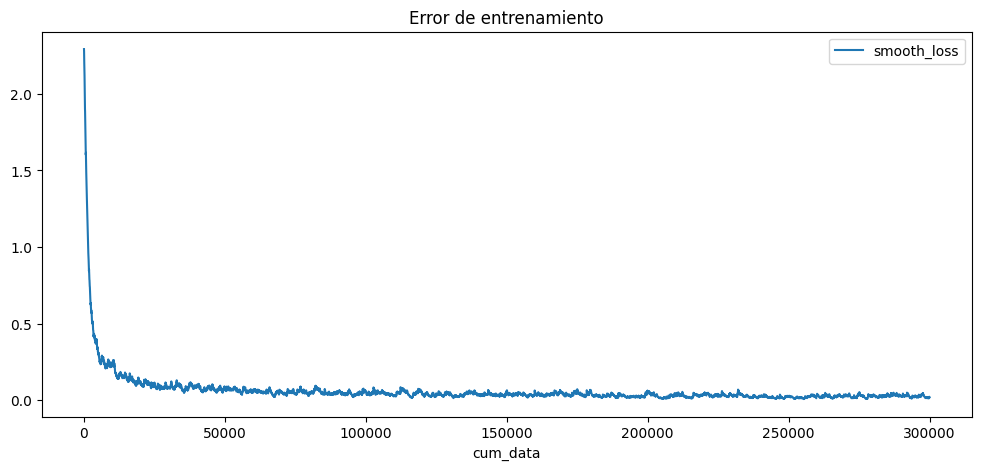

In [13]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="Error de entrenamiento")

En su artículo, los autores también comparan este clasificador con MLP simple de 1 capa, con ResNet con arquitectura similar y con la misma arquitectura EDO, pero en la que los gradientes se propagan directamente a través de ODESolve (sin método de gradiente adjunto) (RK-Net).

!["Methods comparison"](assets/methods_compare.png)
<div align="center">Figura del articulo orginal</div>

Según ellos, MLP de 1 capa con aproximadamente la misma cantidad de parámetros que la red EDO Neuronal tiene un error de prueba mucho mayor, ResNet con aproximadamente el mismo error tiene muchos más parámetros y RK-Net con retropropagación directa a través de ODESolver tiene un error ligeramente mayor y un uso de memoria en crecimiento lineal.

En su artículo, los autores utilizan un solucionador implícito de Runge-Kutta con un tamaño de paso adaptativo en lugar del método simple de Euler (seria interesante programarlo, un par de lineas de codigo mas). También examinan algunas características de la red EDO.

!["Node attrs"](assets/ode_solver_attrs.png)

<div align="center">Características de red EDO (NFE Forward - número de evaluaciones de función durante el pase de avance)</div>
<div align="center">Figura del articulo original</div>

- (a) Cambiar el error numérico tolerable varía el número de pasos por evaluación de pase hacia adelante.
- (b) El tiempo empleado por la llamada de reenvío es proporcional al número de evaluaciones de funciones.
- (c) El número de evaluaciones hacia atrás es aproximadamente la mitad del número de evaluaciones hacia adelante, lo que sugiere que el método adjunto es más eficiente desde el punto de vista computacional que la propagación hacia atrás directa a través de ODESolver.
- (d) A medida que ODE-Net se capacita más y más, demanda más y más evaluaciones, presumiblemente adaptándose a la creciente complejidad del modelo.

## Modelo generativo de series temporales de funciones latentes

La EDO neuronal parece ser más adecuada para datos secuenciales continuos incluso cuando esta trayectoria continua se encuentra en algún espacio latente desconocido.

En esta sección, experimentaremos con la generación de datos secuenciales continuos usando EDO Neuronal y exploraremos un poco su espacio latente.
Los autores también lo comparan con los mismos datos secuenciales pero generados con Redes Neuronales Recurrentes.

El enfoque aquí es ligeramente diferente del ejemplo correspondiente en el repositorio de autores, el de aquí tiene un conjunto más diverso de trayectorias.

### Data

Los datos de entrenamiento consisten en espirales aleatorias, una mitad de las cuales es en el sentido de las agujas del reloj y otra en el sentido contrario a las agujas del reloj. Luego, se muestrean subintervalos de tiempo aleatorios de tamaño 100 de estas espirales, después de haber pasado a través del modelo rnn del codificador en orden inverso, lo que produce un estado inicial latente, que luego evoluciona creando una trayectoria en el espacio latente. Esta trayectoria latente luego se mapea en la trayectoria del espacio de datos y se compara con las observaciones de datos reales. Por lo tanto, el modelo aprende a generar trayectorias similares a datos.

![image.png](assets/spirals_examples.png)
<div align="center">Ejemplos de espirales en el conjunto de datos</div>

### VAE como modelo generativo

Un modelo generativo a través del procedimiento de muestreo:
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
\text{each } x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

Que se puede entrenar utilizando el enfoque de codificador automático variacional:

1. Ejecutamos el codificador RNN a través de la serie temporal hacia atrás en el tiempo para inferir los parámetros $\mu_{z_{t_0}}$, $\sigma_{z_{t_0}}$ del posterior variacional y muestrearlo
$$
z_{t_0} \sim q \left( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q \right) = \mathcal{N} \left(z_{t_0} \mid \mu_{z_{t_0}} \sigma_{z_{t_0}} \right)
$$
2. Obtenemos la trayectoria latente
$$
z_{t_1}, z_{t_2},...,z_{t_N} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_N), \text{ donde } \frac{d z}{d t} = f(z, t; \theta_f)
$$
3. Mapeamos la trayectoria latente en el espacio de datos utilizando otra red neuronal: $\hat{x_{t_i}}(z_{t_i}, t_i; \theta_x)$
4. Maximizamos la estimación del límite inferior de la evidencia para la trayectoria muestreada
$$
\text{ELBO} \approx N \Big( \sum_{i=0}^{M} \log p(x_{t_i} \mid z_{t_i}(z_{t_0}; \theta_f); \theta_x) + KL \left( q( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q) \parallel \mathcal{N}(0, I) \right) \Big)
$$
Y en caso de Gaussian posterior $p(x \mid z_{t_i};\theta_x)$ y nivel de ruido conocido $\sigma_x$
$$
\text{ELBO} \approx -N \Big( \sum_{i=1}^{M}\frac{(x_i - \hat{x_i} )^2}{\sigma_x^2} - \log \sigma_{z_{t_0}}^2 + \mu_{z_{t_0}}^2 + \sigma_{z_{t_0}}^2 \Big) + C
$$

El gráfico de cálculo del modelo EDO latente se puede representar así

![vae_model](assets/vae_model.png)
<div align="center">Figura del articulo original</div>

Luego se puede probar cómo este modelo extrapola la trayectoria solo a partir de sus observaciones del momento inicial.

### Generacion de la dataset

In [14]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generar parámetros de espirales aleatorias
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  sentido contrario a las agujas del reloj
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

C:\Users\Det-Pc\AppData\Local\Temp\ipykernel_3052\2578961546.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_np = np.arange(0, n_points, 1, dtype=np.int)


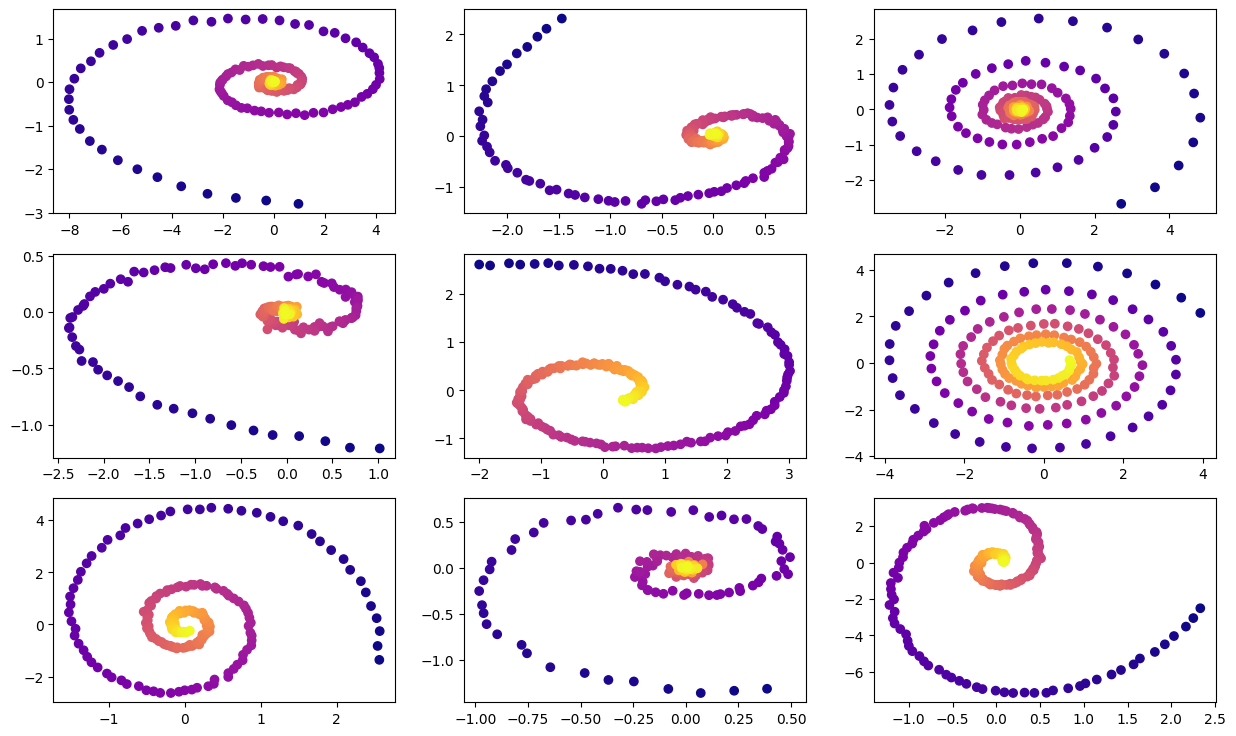

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [16]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Entrenamiento

In [17]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

In [18]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

Epoch 199


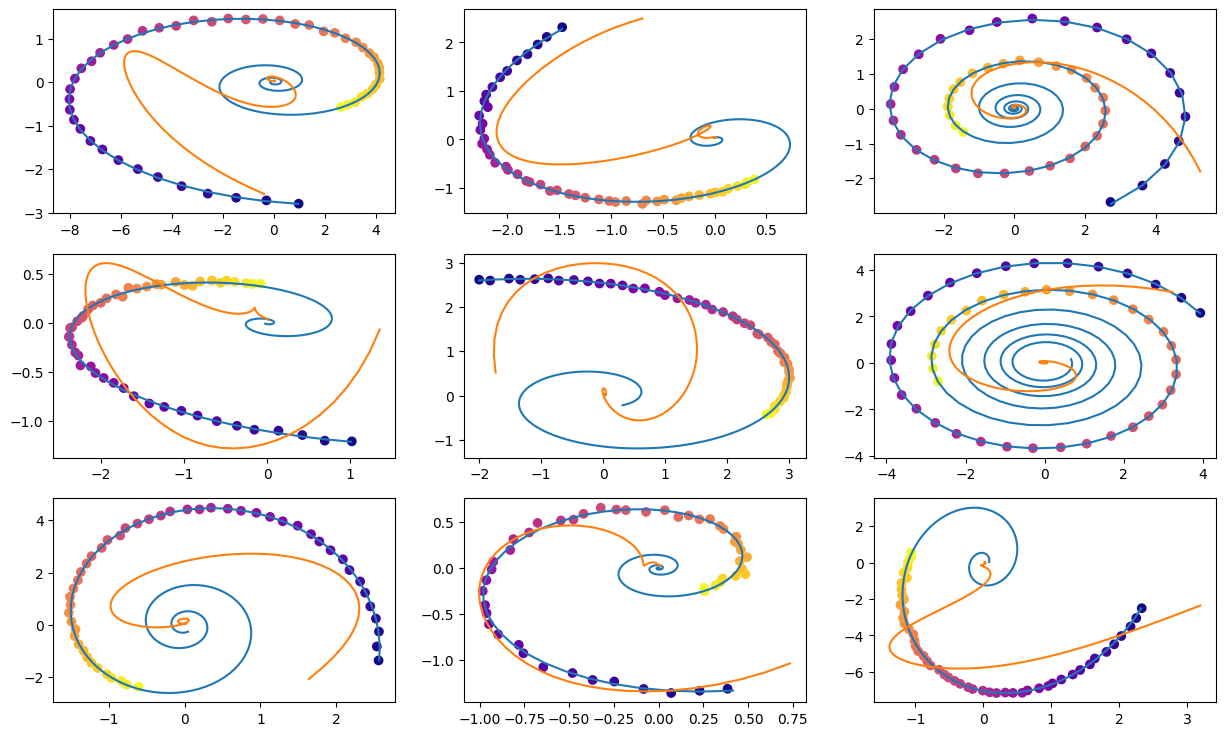

556.9921051025391 511.61839294433594


In [19]:
preload = False
n_epochs = 200#20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("results/models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    # para limpiar los prints
    # Comentar bajo su propio riesgo :3
    clear_output(wait=True)

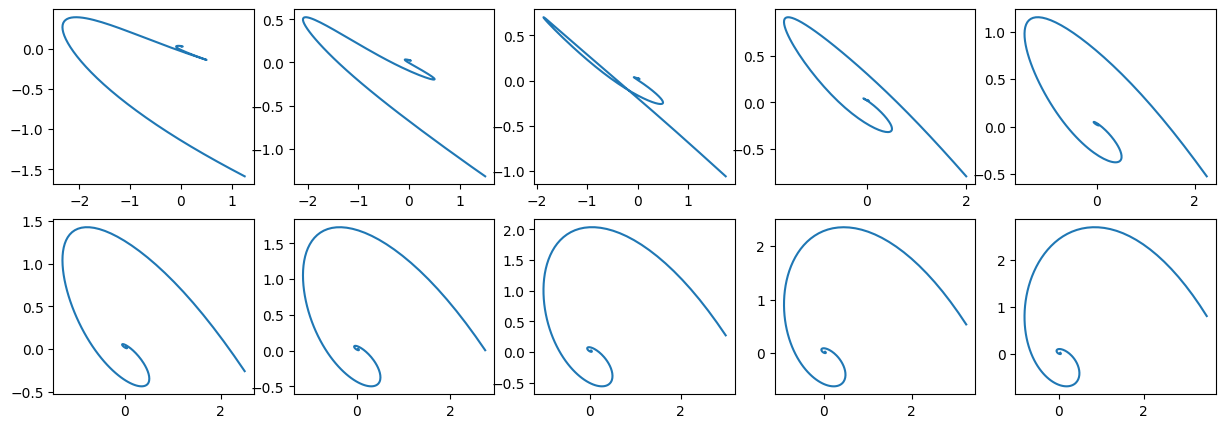

In [20]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

In [21]:
torch.save(vae.state_dict(), "results/models/vae_spirals.sd")

Esto es lo que obtuve después de una noche de entrenamiento.

![spiral reconstruction with seed](assets/spirals_reconstructed.png)
<div align="center">Los puntos son observaciones ruidosas de las trayectorias originales (azul), <br /> amarillo son trayectorias reconstruidas e interpoladas usando puntos como entradas. <br /> El color de los puntos representa el tiempo. </div>

Las reconstrucciones de algunos ejemplos no son muy buenas. Tal vez el modelo no sea lo suficientemente complejo o no haya sido entrenado durante el tiempo suficiente. De todos modos, los resultados parecen muy creíbles.

Ahora echemos un vistazo a lo que sucede si interpolamos la variable latente de la trayectoria en el sentido de las agujas del reloj a otra, la del sentido contrario a las agujas del reloj.

![homotopy](assets/spirals_homotopy.png)

Los autores también comparan las trayectorias reconstruidas usando observaciones iniciales del momento del tiempo de Neural ODE y RNN simple.

![ode_rnn_comp](assets/ode_rnn_comp.png)
<div align="center">Figura del articulo original</div>

## Flujos de normalización continuos

El artículo original también contribuye mucho en el tema de la normalización de flujos. Los flujos de normalización se utilizan cuando se necesita muestrear una distribución complicada que se origina a partir de un cambio de variables en alguna distribución simple (por ejemplo, gaussiana), sin dejar de conocer la densidad de probabilidad de cada muestra.
Muestran que el uso del cambio continuo de variables es mucho más eficiente e interpretable desde el punto de vista computacional que los métodos anteriores._

Los flujos de normalización son muy útiles en modelos como *Codificadores automáticos variacionales*, *Redes neuronales bayesianas* y otras cosas en la configuración bayesiana.

Este tema, sin embargo, está más allá del alcance del presente cuaderno, y aquellos interesados están dirigidos al documento original.

Para molestarte un poco:

![CNF_NF_comp](assets/CNF_NF_comp.png)

<div align="center">Visualizar la transformación de ruido (distribución simple) a datos (distribución complicada) para dos conjuntos de datos; <br /> El eje X representa la densidad y la transformación de muestras con "tiempo" (para CNF) y "profundidad" (para NF) <br />Figura del articulo original</div>

# Links utiles

   - [Articulo Original](https://arxiv.org/abs/1806.07366)
   - [Implementación PyTorch de los autores](https://github.com/rtqichen/torchdiffeq)
   - [Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)
   - [VAE ecplicado](https://www.jeremyjordan.me/variational-autoencoders/)
   - [Más sobre la normalización de flujos](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
   - [Inferencia variacional con normalización de flujos Paper](https://arxiv.org/abs/1505.05770)